<span style="color:red">This notebook is an adapted version from  </span>  http://pyro.ai/examples/bayesian_regression.html

## Setup
Let's begin by installing and importing the modules we'll need.

In [1]:
!pip install -q --upgrade torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

# ignore future warnings 
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Dataset 

The following example is taken from \[1\].  We would like to explore the relationship between topographic heterogeneity of a nation as measured by the Terrain Ruggedness Index (variable *rugged* in the dataset) and its GDP per capita. In particular, it was noted by the authors in \[1\] that terrain ruggedness or bad geography is related to poorer economic performance outside of Africa, but rugged terrains have had a reverse effect on income for African nations. Let us look at the data \[2\] and investigate this relationship.  We will be focusing on three features from the dataset:
  - `rugged`: quantifies the Terrain Ruggedness Index
  - `cont_africa`: whether the given nation is in Africa
  - `rgdppc_2000`: Real GDP per capita for the year 2000
 
  
We will take the logarithm for the response variable GDP as it tends to vary exponentially. We also use a new variable `african_rugged`, defined as the product between the variables `rugged` and `cont_africa`, to capture the correlation between ruggedness and whether a country is in Africa.

In [2]:
DATA_URL = "https://raw.githubusercontent.com/PGM-Lab/probai-2021-pyro/main/Day1/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
df["african_rugged"] = data["cont_africa"] * data["rugged"]
df = df[["cont_africa", "rugged", "african_rugged", "rgdppc_2000"]]

# Divide the data into predictors and response and store the data in numpy arrays
data_array = np.array(df)
x_data = data_array[:, :-1]
y_data = data_array[:, -1]

In [3]:
# Display first 10 entries 
display(df[0:10])

,cont_africa,rugged,african_rugged,rgdppc_2000
2,1,0.858,0.858,7.492609
4,0,3.427,0.000,8.216929
7,0,0.769,0.000,9.933263
8,0,0.775,0.000,9.407032
9,0,2.688,0.000,7.792343
11,0,0.006,0.000,9.212541
12,0,0.143,0.000,10.143191
13,0,3.513,0.000,10.274632
14,0,1.672,0.000,7.852028
15,1,1.780,1.780,6.432380


# 1. Linear Regression

Regression is one of the most common and basic supervised learning tasks in machine learning. Suppose we're given a dataset $\mathcal{D}$ of the form

$$ \mathcal{D}  = \{ (X_i, y_i) \} \qquad \text{for}\qquad i=1,2,...,N$$

The goal of linear regression is to fit a function to the data of the form:

$$ y = w X + b + \epsilon $$

where $w$ and $b$ are learnable parameters and $\epsilon$ represents observation noise. Specifically $w$ is a matrix of weights and $b$ is a bias vector.

Let's first implement linear regression in PyTorch and learn point estimates for the parameters $w$ and $b$.  Then we'll see how to incorporate uncertainty into our estimates by using Pyro to implement Bayesian regression.

[Text(0, 0.5, 'log GDP (2000)'),
 Text(0.5, 0, 'Terrain Ruggedness Index'),
 Text(0.5, 1.0, 'African Nations')]

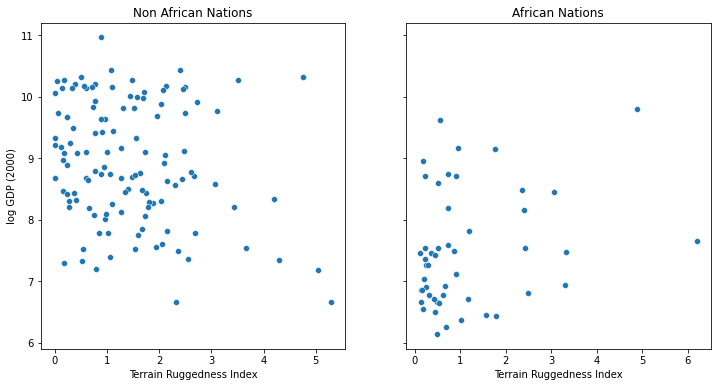

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = data[data["cont_africa"] == 1]
non_african_nations = data[data["cont_africa"] == 0]
sns.scatterplot(non_african_nations["rugged"], 
            np.log(non_african_nations["rgdppc_2000"]), 
            ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(african_nations["rugged"], 
            np.log(african_nations["rgdppc_2000"]), 
            ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

## 1.1 Model
We would like to predict log GDP per capita of a nation as a function of three features from the dataset - whether the nation is in Africa, its Terrain Ruggedness Index, and the interaction between these two.  Let's define our regression model. We'll define an specific object encapsulating this linear regression model.  Our input `x_data` is a tensor of size $N \times 3$ and our output `y_data` is a tensor of size $N \times 1$.  The method `predict(self,x_data)` defines a linear transformation of the form $Xw + b$ where $w$ is the weight matrix and $b$ is the additive bias.

The parameters of the model are defined using ``torch.nn.Parameter``, and will be learned during training. 

In [5]:
class RegressionModel():
    def __init__(self):
        self.w = torch.nn.Parameter(torch.zeros(1, 3))
        self.b = torch.nn.Parameter(torch.zeros(1, 1))

    def params(self):
        return {"b":self.b, "w": self.w}

    def predict(self, x_data):
        return (self.b + torch.mm(self.w, torch.t(x_data))).squeeze(0)

regression_model = RegressionModel()

## 1.2 Training
We will use the mean squared error (MSE) as our loss and Adam as our optimizer. We would like to optimize the parameters of the `regression_model` neural net above. We will use a somewhat large learning rate of `0.05` and run for 1000 iterations.

In [6]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(regression_model.params().values(), lr=0.05)
num_iterations = 5000
data_array = torch.tensor(df.values, dtype=torch.float)
x_data, y_data = data_array[:, :-1], data_array[:, -1]

def main():
    x_data = data_array[:, :-1]
    y_data = data_array[:, -1]
    for j in range(num_iterations):
        # run the model forward on the data
        y_pred = regression_model.predict(x_data)
        # calculate the mse loss
        loss = loss_fn(y_pred, y_data)
        # initialize gradients to zero
        optim.zero_grad()
        # backpropagate
        loss.backward()
        # take a gradient step
        optim.step()
        if (j + 1) % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))
    # Inspect learned parameters
    print("Learned parameters:")
    for name, param in regression_model.params().items():
        print(name, param.data.numpy())

main()

[iteration 0500] loss: 208.7967
[iteration 1000] loss: 147.9409
[iteration 1500] loss: 147.8815
[iteration 2000] loss: 147.8815
[iteration 2500] loss: 147.8815
[iteration 3000] loss: 147.8815
[iteration 3500] loss: 147.8815
[iteration 4000] loss: 147.8815
[iteration 4500] loss: 147.8815
[iteration 5000] loss: 147.8815
Learned parameters:
b [[9.223223]]
w [[-1.9480442  -0.2028555   0.39339212]]


## 1.3 Evaluating the model

We now plot the regression line learned for african and non-african nations relating the rugeedness index with the GDP of the country.

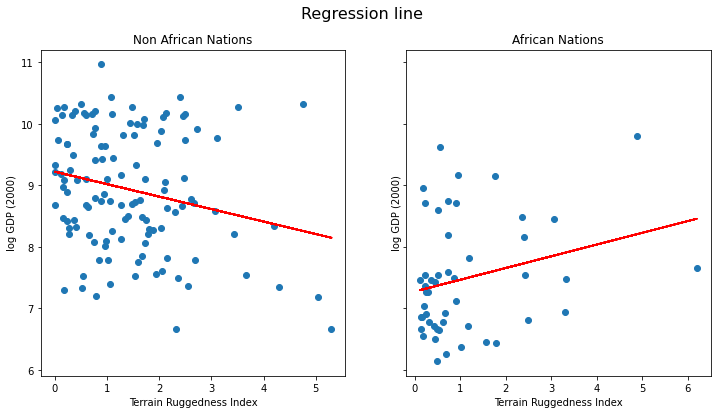

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Regression line ", fontsize=16)
ax[0].scatter(x_data[x_data[:,0]==0,1].detach().numpy(), y_data[x_data[:,0]==0].detach().numpy())
ax[1].scatter(x_data[x_data[:,0]==1,1].detach().numpy(), y_data[x_data[:,0]==1].detach().numpy())

for i in range(10):
    ax[0].plot(x_data[x_data[:,0]==0,1].detach().numpy(),regression_model.predict(x_data[x_data[:,0]==0,:]).detach().numpy(), color='r')
    ax[1].plot(x_data[x_data[:,0]==1,1].detach().numpy(),regression_model.predict(x_data[x_data[:,0]==1,:]).detach().numpy(), color='r')

ax[0].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="Non African Nations")
ax[1].set(xlabel="Terrain Ruggedness Index",ylabel="log GDP (2000)",title="African Nations")

plt.show()

## 1.4 The relationship between ruggedness and log GPD



Using this analysis, we can estimate the relationship between ruggedness and log GPD. As can be seen, this relationship is positive for African nations, but negative for Non African Nations.

In [8]:
slope_within_africa = regression_model.params()['w'][0,1] + regression_model.params()['w'][0,2]
slope_outside_africa = regression_model.params()['w'][0,1]
print(slope_within_africa.detach().numpy())
print(slope_outside_africa.detach().numpy())

0.19053662
-0.2028555


# 2. Bayesian Linear Regression


[Bayesian modeling](http://mlg.eng.cam.ac.uk/zoubin/papers/NatureReprint15.pdf) offers a systematic framework for reasoning about model uncertainty. Instead of just learning point estimates, we're going to learn a _distribution_ over variables that is consistent with the observed data.

In order to make our linear regression Bayesian, we need to put priors on the parameters $w$ and $b$. These are distributions that represent our prior belief about reasonable values for $w$ and $b$ (before observing any data).

## 2.1 Model

We now have all the ingredients needed to specify our model. First we define priors over weights and bias. Note the priors that we are using for the different latent variables in the model. 

The following figures shows a graphical description of the model: 

<img src="https://github.com/PGM-Lab/probai-2021-pyro/raw/main/Day2/Figures/BayesianLinearRegressionModel.png" alt="Drawing" width=800 >


## 2.2 Full mean field
First we consider a full mean filed approach, where the variational approximation factorizes as
$$
q({\bf w}, b) = q(b)\prod _{i=1}^Mq(w_i)
$$


### Helper-routine: Calculate ELBO

In [9]:
def calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec):
    """
    Helper routine: Calculate ELBO. Data is the sampled x and y values, gamma is the prior precision over the 
    weights and theta is the prior precision associated with y. Everything prefixed a 'q' relates to the 
    variational posterior.
    
    Note: This function obviously only works for this particular model and is not a general solution.

    :param x_data: The predictors
    :param y_data: The response variable
    :param gamma_w: prior precision for the weights
    :param gamma_b: prior precision for the intercept
    :param theta: prior precision for y
    :param q_w_mean: VB posterior mean for the distribution of the weights w 
    :param q_w_prec: VB posterior precision for the distribution of the weights w 
    :param q_b_mean: VB posterior mean for the intercept b
    :param q_b_prec: VB posterior precision for the intercept b
    :return: the ELBO
    """
    
    # We calculate the ELBO as E_q log p(y,x,w,b) - E_q log q(w,b), where
    # log p(y,x,w) = sum_i log p(y|x,w,b) + log p(w) + log p(b)
    # log q(w,b) = log q(w) + log q(b)

    M = x_data.shape[1]

    # E_q log p(w)
    E_log_p = -0.5 * M * np.log(2 * np.pi) + 0.5 * M * gamma_w - 0.5 * gamma_w * np.sum(np.diagonal(np.linalg.inv(q_w_prec))
                                                                                    + (q_w_mean*q_w_mean).flatten())
    # E_q log p(b)
    E_log_p += -0.5 * np.log(2 * np.pi) + 0.5 * np.log(gamma_b) - 0.5 * gamma_b * (1/q_b_prec + q_b_mean**2)

    # sum_i E_q log p(y|x,w,b)
    E_w_w = np.linalg.inv(q_w_prec) + q_w_mean @ q_w_mean.transpose()
    E_b_b = 1/q_b_prec + q_b_mean**2
    for i in range(x_data.shape[0]):
        E_x_ww_x = np.matmul(x_data[i, :].transpose(), np.matmul(E_w_w, x_data[i, :]))
        E_log_p += -0.5 * np.log(2 * np.pi) + 0.5 * np.log(theta) \
                   - 0.5 * theta * (y_data[i]**2 + E_x_ww_x + E_b_b
                                    + 2 * q_b_mean * np.matmul(q_w_mean.transpose(), x_data[i, :])
                                    - 2 * y_data[i] * np.matmul(q_w_mean.transpose(), x_data[i,:])
                                    - 2 * y_data[i] * q_b_mean)

    # Entropy of q_b
    ent = 0.5 * np.log(1 * np.pi * np.exp(1) / q_b_prec)
    ent += 0.5 * np.log(np.linalg.det(2 * np.pi * np.exp(1) * np.linalg.inv(q_w_prec)))

    return E_log_p - ent

### <span style="color:red">Exercise 1: Introduce the variational updating rules</span> 


* Variational updating rules for $q(w_i)$ (already implemented below).
  - Updating equation for **precision** of $q(w_i)$: 
$$
\tau \leftarrow (\gamma_w+\theta\sum_{i=1}^N(x_{ij}^2))
$$
  - Updating equation for **mean** of $q(w_i)$: 
$$\mu \leftarrow \tau^{-1}\theta\sum_{i=1}^Nx_{ij}(y_i - (\sum_{k\neq j}x_{ik}\mathbb{E}(W_k)+\mathbb{E}(B)))
$$

* Introduce variational updating rules for $q(b)$, which is normally distributed.
  - Updating equation for **precision** of $q(w_i)$: 
$$
\tau \leftarrow (\gamma_b+\theta N)
$$
  - Updating equation for **mean** of $q(w_i)$: 
$$
\mu \leftarrow \tau^{-1} \theta\sum_{i=1}^N(y_i -
              \mathbb{E}(\mathbf{W}^T)\mathbf{x}_i)
$$


In [10]:
# The variational updating rule for weight component 'comp'
def update_w_comp(x_data, y_data, gamma_w, theta, q_w_mean, q_w_prec, q_b_mean, comp):

    # Lenght of weight vector
    M = x_data.shape[1]
    # The precision (a scalar)
    Q = gamma_w
    # The mean (a scalar)
    mu = 0.0
    for i in range(x_data.shape[0]):
        Q += theta * x_data[i, comp]**2
        mu += (y_data[i] - q_b_mean - (np.sum(x_data[i, :] @ q_w_mean) - x_data[i, comp]*q_w_mean[comp])) \
                * x_data[i, comp]
    mu = theta * 1/Q * mu

    # Update the appropriate entries in the mean vector and precision matrix
    q_w_prec[comp, comp] = Q
    q_w_mean[comp] = mu.item()

    return q_w_prec, q_w_mean


Now you have to code the variational updating rule for the intercetp $B$. This updating rule only depends on $\textbf{x}$, $\textbf{y}$, $\gamma_b$, $\theta$ and the mean of the variational posterior distribution over the weights $\textbf{W}$.

In [11]:
# The variational updating rule for the intercept
def update_b(x_data, y_data, gamma_b, theta, q_w_mean):

    N = x_data.shape[0]

    # The precision (a scalar)
    tau = gamma_b + N*theta
    # The mean (a scalar)
    mu = 1/tau * theta * np.sum(y_data - np.sum(q_w_mean.T * x_data, axis=-1))

    return tau, mu

## 2.3 Inference

To do inference we'll use coordinate ascent, which is implemented by the above updating rules. Just like in the non-Bayesian linear regression, each iteration of our training objective will be optimzed, with the difference that in this case, we'll use the ELBO objective instead of the MSE loss. 


   VB iterations:
Iteration  0. ELBO:  -894.7835565
Iteration  1. ELBO:  -563.6201556
Iteration  2. ELBO:  -427.8605484
Iteration  3. ELBO:  -358.8879551
Iteration  4. ELBO:  -321.7490694
Iteration  5. ELBO:  -300.9904273
Iteration  6. ELBO:  -289.1335589
Iteration  7. ELBO:  -282.2779081
Iteration  8. ELBO:  -278.2866417
Iteration  9. ELBO:  -275.9539940
Iteration 10. ELBO:  -274.5877450
Iteration 11. ELBO:  -273.7865459
Iteration 12. ELBO:  -273.3163823
Iteration 13. ELBO:  -273.0403721
Iteration 14. ELBO:  -272.8783047
Iteration 15. ELBO:  -272.7831305
Iteration 16. ELBO:  -272.7272356
Iteration 17. ELBO:  -272.6944077
Iteration 18. ELBO:  -272.6751271
Iteration 19. ELBO:  -272.6638029
Iteration 20. ELBO:  -272.6571517
Iteration 21. ELBO:  -272.6532453
Iteration 22. ELBO:  -272.6509509
Iteration 23. ELBO:  -272.6496032
Iteration 24. ELBO:  -272.6488117
Iteration 25. ELBO:  -272.6483468
Iteration 26. ELBO:  -272.6480738
Iteration 27. ELBO:  -272.6479134
Iteration 28. ELBO:  -272.647

Text(0, 0.5, 'ELBO')

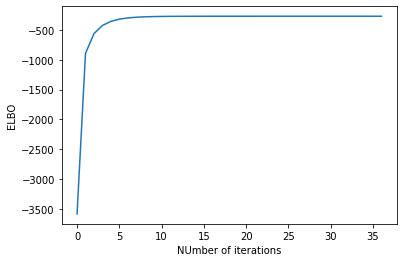

In [12]:
# Initialize the variational distributions
data_array = np.array(df)
x_data = data_array[:, :-1]
y_data = data_array[:, -1]
M = x_data.shape[1]
gamma_w = 1
gamma_b = 1
theta = 1
q_w_mean = np.random.normal(0, 1, (3, 1))
q_w_prec = np.diag((1, 1, 1))
q_b_mean = np.random.normal(0, 1)
q_b_prec = 1
elbos = []

# Calculate ELBO
this_lb = calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec)
elbos.append(this_lb)
previous_lb = -np.inf
# Start iterating
print("\n" + 100 * "=" + "\n   VB iterations:\n" + 100 * "=")
for iteration in range(100):

    # Update the variational distributions
    for i in range(M):
        q_w_prec, q_w_mean = update_w_comp(x_data, y_data, gamma_w, theta, q_w_mean, q_w_prec, q_b_mean, i)
    q_b_prec, q_b_mean = update_b(x_data, y_data, gamma_b, theta, q_w_mean)

    this_lb = calculate_ELBO(x_data, y_data, gamma_w, gamma_b, theta, q_w_mean, q_w_prec, q_b_mean, q_b_prec)
    elbos.append(this_lb)

    print(f"Iteration {iteration:2d}. ELBO: {this_lb.item():13.7f}")
    if this_lb < previous_lb:
        raise ValueError("ELBO is decreasing. Something is wrong! Goodbye...")
    
    if iteration > 0 and np.abs((this_lb - previous_lb) / previous_lb) < 1E-8:
        # Very little improvement. We are done.
        break
    
    # If we didn't break we need to run again. Update the value for "previous"
    previous_lb = this_lb
print("\n" + 100 * "=" + "\n")

# Store the results
w_mean_mf = q_w_mean
w_prec_mf = q_w_prec
b_mean_mf = q_b_mean
b_prec_mf = q_b_prec

plt.plot(range(len(elbos)), elbos)
plt.xlabel('NUmber of iterations')
plt.ylabel('ELBO')

Now, we have a Gaussian posterior for $q(b)$ and $q(w)$ with means and precisions:

In [13]:
print("Mean q(b):", b_mean_mf)
print("Precision q(b):", b_prec_mf)
print("Mean q(w):", w_mean_mf)
print("Precision q(w):", w_prec_mf)


Mean q(b): 8.98662401749148
Precision q(b): 171
Mean q(w): [[-1.64818323]
 [-0.09842656]
 [ 0.26234871]]
Precision q(w): [[ 50   0   0]
 [  0 533   0]
 [  0   0 139]]


Note that instead of just point estimates, we now have uncertainty estimates for our learned parameters.

## 2.4  Model's Uncertainty
We can now sample different regression lines from the variational posteriors, thus reflecting the model uncertainty.

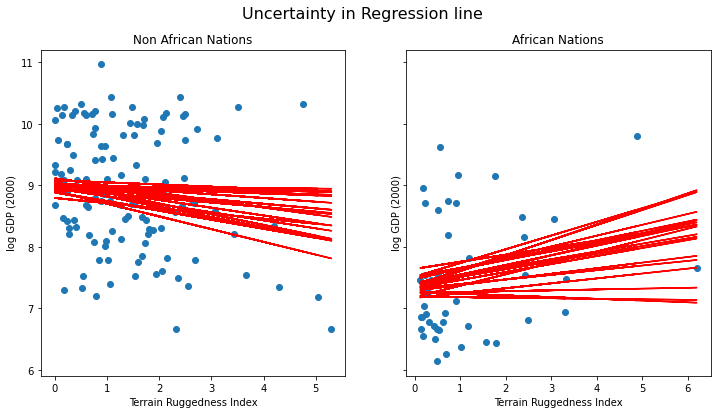

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Uncertainty in Regression line ", fontsize=16)
num_samples = 20

ax[0].scatter(x_data[x_data[:,0]==0,1], y_data[x_data[:,0]==0])
for _ in range(num_samples):
    b_sample = np.random.normal(loc=q_b_mean, scale=1/np.sqrt(q_b_prec))
    w_sample = np.random.multivariate_normal(mean=q_w_mean.flatten(), cov=np.linalg.inv(q_w_prec))
    ax[0].plot(x_data[x_data[:,0]==0,1], (x_data[x_data[:,0]==0,:] @ w_sample)+b_sample, 'r-')
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")

ax[1].scatter(x_data[x_data[:,0]==1,1], y_data[x_data[:,0]==1])
for _ in range(num_samples):
    b_sample = np.random.normal(loc=q_b_mean, scale=1/np.sqrt(q_b_prec))
    w_sample = np.random.multivariate_normal(mean=q_w_mean.flatten(), cov=np.linalg.inv(q_w_prec))
    ax[1].plot(x_data[x_data[:,0]==1,1], (x_data[x_data[:,0]==1,:] @ w_sample)+b_sample, 'r-')
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations")

plt.show()

The above figure shows the uncertainty in our estimate of the regression line. Note that for lower values of ruggedness there are many more data points, and as such, the regression lines are less uncertainty than in high ruggness values, where there is much more uncertainty, specially in the case of African nations. 

## 2.5 The relationship between ruggedness and log GPD

Finally, we go back to the previous analysis about the relationship between ruggedness and log GPD. Now, we can compute uncertainties over this relationship. As can be seen, this relationship is negative for Non African Nations with high probability, and positive for African nations in most of the cases. But there is non-negligible probability that this is relationship is also negative. This is the consequence of the low number of samples in the case of African nations.

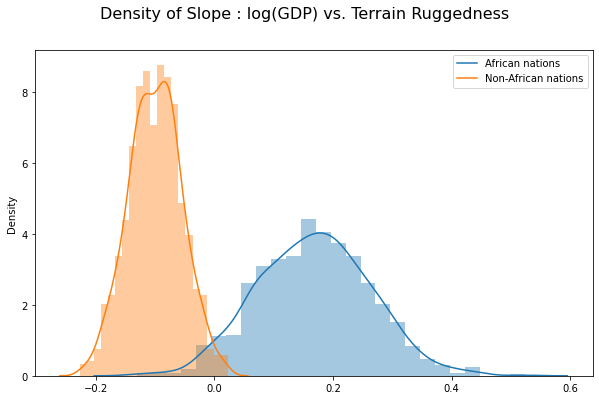

In [15]:
weight = np.random.multivariate_normal(mean=q_w_mean.flatten(), cov=np.linalg.inv(q_w_prec),size=1000)
gamma_within_africa = weight[:,1] + weight[:,2]
gamma_outside_africa = weight[:,1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness", fontsize=16)
plt.legend()
plt.show()

### References
  1. McElreath, D., *Statistical Rethinking, Chapter 7*, 2016
  2. Nunn, N. & Puga, D., *[Ruggedness: The blessing of bad geography in Africa"](https://diegopuga.org/papers/rugged.pdf)*, Review of Economics and Statistics 94(1), Feb. 2012